In [2]:
import sys
import os

sys.path.append(os.path.abspath("../src"))

import generations
import search_space
import data_preprocessing as dp

import baseline_models as bm
from instance_sampling import create_dataloaders

In [12]:
# DATA_ID = 41143
# DATA_ID = 31
DATA_ID = 54
X_train, y_train, X_val, y_val, X_test, y_test = dp.get_preprocessed_data(
        dataset_id=DATA_ID, scaling=True, random_seed=13, return_as='tensor', task_type='classification')

# sample row 56
print(X_train[56], y_train[56])

Trying with Dataset: vehicle
Class column is not numeric. Applying LabelEncoder.
Data loaded successfully! Format: tensor
Training data shape: torch.Size([540, 18])
y_training data shape: torch.Size([540])
tensor([ 0.4196,  0.0118,  0.3634,  0.1528,  0.8222,  0.4100, -0.3638,  0.2742,
        -0.2267,  0.6259, -0.5015, -0.4306, -0.5676, -0.7777,  0.3033, -0.0679,
         0.5025,  0.5874]) tensor(3)


In [3]:
baseline_metric, time_budget, scoreboard = bm.get_models_and_baseline_metric(X_train, y_train, n_models=20)
print("Baseline metric:", baseline_metric)
print("Time budget for baseline models:", time_budget)
display(scoreboard)
time_budget = time_budget * 3 # Since NN models require more time, the time budget gets tripled
# baseline_metric = 0.5

Baseline metric: 0.7333
Time budget for baseline models: 82.52506136894226


,pipeline,accuracy
28,"(StandardScaler(), PCA(), MLPClassifier())",0.8463
21,"(StandardScaler(), MLPClassifier())",0.8204
14,(MLPClassifier()),0.8148
8,(QuadraticDiscriminantAnalysis()),0.8111
20,"(RobustScaler(), MLPClassifier())",0.8019
23,"(StandardScaler(), FastICA(), MLPClassifier())",0.8000
18,"(PowerTransformer(), MLPClassifier())",0.7981
122,"(StandardScaler(), PCA(n_components=0.98632369...",0.7944
7,(LinearDiscriminantAnalysis()),0.7852
22,"(VarianceThreshold(), MLPClassifier())",0.7852


In [4]:
input_size, output_size = dp.get_tensor_sizes(X_train, y_train)
search_space = search_space.SearchSpace(input_size=input_size, output_size=output_size)

In [5]:
N_INDIVIDUALS = 200 # amount of architectures to be evaluated as a starting point
N_EPOCHS = 100
percentile_drop = 15 # drop the worst 5% of architectures after first epoch

In [6]:
# The generation is created given the search space and the number of individuals.
generation = generations.Generation(search_space, N_INDIVIDUALS, starting_instances=1000)

In [7]:
generation.run_ebe(epochs=N_EPOCHS,
                    X_train=X_train,
                    y_train=y_train,
                    X_val=X_val,
                    y_val=y_val, 
                    percentile_drop=percentile_drop,
                    baseline_metric=baseline_metric, 
                    time_budget=time_budget,
                    epoch_threshold=3
                    )

Epoch 1/100 - Running EBE
Epoch 2/100 - Running EBE
Epoch 3/100 - Running EBE
Epoch 4/100 - Running EBE
Epoch 5/100 - Running EBE
Epoch 6/100 - Running EBE
Epoch 7/100 - Running EBE
Epoch 8/100 - Running EBE
Epoch 9/100 - Running EBE
Epoch 10/100 - Running EBE
Epoch 11/100 - Running EBE
Epoch 12/100 - Running EBE
Time budget exceeded at epoch 13: 265.72 seconds


In [8]:
results_df = generation.return_df()
display(results_df)

,hidden_layers,activation_fn,dropout_rate,optimizer_type,learning_rate,weight_decay,momentum,batch_size,use_skip_connections,initializer,...,train_loss,train_acc,val_loss,val_acc,efforts,n_instances,fcst_accuracy,higher_than_baseline,last_epoch_val_acc,last_epoch_val_loss
0,"[188, 261, 485, 169, 410, 93, 366, 308]",<class 'torch.nn.modules.activation.ReLU'>,0.1,<class 'torch.optim.adam.Adam'>,0.000884,0.00001,NaN,1024,True,xavier_uniform,...,"[1.3890666961669922, 1.381540060043335, 1.3724...","[0.26296296296296295, 0.26666666666666666, 0.3...","[1.3905688524246216, 1.3788292407989502, 1.360...","[0.21323529411764705, 0.34558823529411764, 0.3...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[540, 540, 540, 540, 540, 540, 540, 540, 540, ...",0.906514,True,0.654412,0.744772
1,"[154, 419, 485, 169, 410, 93, 366, 308]",<class 'torch.nn.modules.activation.ReLU'>,0.1,<class 'torch.optim.adam.Adam'>,0.001015,0.00000,NaN,32,True,kaiming_uniform,...,"[1.3996509790420533, 1.0127235271312571, 0.780...","[0.337037037037037, 0.5425925925925926, 0.6611...","[1.0739588036256678, 0.7662547686520744, 0.584...","[0.47058823529411764, 0.625, 0.676470588235294...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]","[540, 540, 540, 540, 540, 540, 540, 540, 540]",0.787244,True,0.750000,0.643189
2,"[480, 296, 59, 458, 414, 92, 7, 61, 98, 218, 2...",<class 'torch.nn.modules.activation.LeakyReLU'>,0.0,<class 'torch.optim.sgd.SGD'>,0.001839,0.00001,0.8,64,True,kaiming_uniform,...,"[1.3787184415040192, 1.3303069520879676, 1.268...","[0.29074074074074074, 0.37592592592592594, 0.4...","[1.3776979446411133, 1.351077542585485, 1.3097...","[0.3088235294117647, 0.375, 0.375, 0.367647058...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[540, 540, 540, 540, 540, 540, 540, 540, 540, ...",0.781930,True,0.661765,0.952359
3,"[272, 313, 325, 281, 250, 259, 433, 82, 409, 272]",<class 'torch.nn.modules.activation.GELU'>,0.0,<class 'torch.optim.adamw.AdamW'>,0.000621,0.00100,NaN,512,False,kaiming_uniform,...,"[1.4827392975489297, 1.242472658333955, 1.0839...","[0.2740740740740741, 0.4185185185185185, 0.525...","[1.3302146196365356, 1.1890952587127686, 0.963...","[0.3235294117647059, 0.49264705882352944, 0.51...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[540, 540, 540, 540, 540, 540, 540, 540, 540, ...",0.778231,True,0.639706,0.786064
4,"[466, 492]",<class 'torch.nn.modules.activation.ELU'>,0.2,<class 'torch.optim.adam.Adam'>,0.005326,0.00010,NaN,64,False,kaiming_normal,...,"[1.7222408285847417, 0.9179039270789535, 0.697...","[0.5055555555555555, 0.6907407407407408, 0.716...","[1.380938643041779, 1.1637084273731007, 1.0432...","[0.5661764705882353, 0.6617647058823529, 0.647...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[540, 540, 540, 540, 540, 540, 540, 540, 540, ...",0.775491,True,0.764706,0.564918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,"[306, 471, 364, 336, 268, 261]",<class 'torch.nn.modules.activation.Tanh'>,0.4,<class 'torch.optim.adam.Adam'>,0.000382,0.00100,NaN,1024,True,xavier_uniform,...,"[1.415333867073059, 1.3482623100280762, 1.2735...","[0.2851851851851852, 0.32222222222222224, 0.40...","[1.2858941555023193, 1.2202867269515991, 1.182...","[0.4485294117647059, 0.5661764705882353, 0.529...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]","[540, 540, 540, 540, 540, 540, 540, 540]",0.535489,False,0.529412,1.082718
96,"[74, 458, 417]",<class 'torch.nn.modules.activation.GELU'>,0.5,<class 'torch.optim.sgd.SGD'>,0.022466,0.00100,0.8,512,False,kaiming_normal,...,"[2.050088788844921, 1.9411933695828474, 1.6711...","[0.28703703703703703, 0.27037037037037037, 0.4...","[1.3806828260421753, 1.2799571752548218, 1.253...","[0.40441176470588236, 0.49264705882352944, 0.5...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]","[540, 540, 540, 540, 540, 540, 540, 540]",0.521777,False,0.514706,1.283215
97,"[306, 98, 466, 43, 225]",<class 'torch.nn.modules.activation.Tanh'>,0.4,<class 'torch.optim.adam.Ad

In [10]:
results_df.tail()

,hidden_layers,activation_fn,dropout_rate,optimizer_type,learning_rate,weight_decay,momentum,batch_size,use_skip_connections,initializer,...,train_loss,train_acc,val_loss,val_acc,efforts,n_instances,fcst_accuracy,higher_than_baseline,last_epoch_val_acc,last_epoch_val_loss
95,"[306, 471, 364, 336, 268, 261]",<class 'torch.nn.modules.activation.Tanh'>,0.4,<class 'torch.optim.adam.Adam'>,0.000382,0.00100,NaN,1024,True,xavier_uniform,...,"[1.415333867073059, 1.3482623100280762, 1.2735...","[0.2851851851851852, 0.32222222222222224, 0.40...","[1.2858941555023193, 1.2202867269515991, 1.182...","[0.4485294117647059, 0.5661764705882353, 0.529...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]","[540, 540, 540, 540, 540, 540, 540, 540]",0.535489,False,0.529412,1.082718
96,"[74, 458, 417]",<class 'torch.nn.modules.activation.GELU'>,0.5,<class 'torch.optim.sgd.SGD'>,0.022466,0.00100,0.8,512,False,kaiming_normal,...,"[2.050088788844921, 1.9411933695828474, 1.6711...","[0.28703703703703703, 0.27037037037037037, 0.4...","[1.3806828260421753, 1.2799571752548218, 1.253...","[0.40441176470588236, 0.49264705882352944, 0.5...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]","[540, 540, 540, 540, 540, 540, 540, 540]",0.521777,False,0.514706,1.283215
97,"[306, 98, 466, 43, 225]",<class 'torch.nn.modules.activation.Tanh'>,0.4,<class 'torch.optim.adam.Adam'>,0.000670,0.01000,NaN,1024,False,xavier_uniform,...,"[1.3981938362121582, 1.3723821640014648, 1.339...","[0.25555555555555554, 0.3, 0.3592592592592593,...","[1.339337706565857, 1.309939980506897, 1.28633...","[0.35294117647058826, 0.3602941176470588, 0.36...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[540, 540, 540, 540, 540, 540, 540, 540, 540, ...",0.480529,False,0.492647,1.146260
98,"[126, 239]",<class 'torch.nn.modules.activation.ELU'>,0.1,<class 'torch.optim.adamw.AdamW'>,0.004131,0.00001,NaN,32,True,kaiming_normal,...,[0.8937095152007208],[0.6314814814814815],[0.7048103458741132],[0.7132352941176471],[1.0],[540],0.000000,False,0.713235,0.704810
99,"[480, 239]",<class 'torch.nn.modules.activation.ReLU'>,0.0,<class 'torch.optim.adam.Adam'>,0.005966,0.00001,NaN,32,False,kaiming_uniform,...,[1.0106312738524543],[0.5833333333333334],[0.7639344159294578],[0.6691176470588235],[1.0],[540],0.000000,False,0.669118,0.763934


In [9]:
results_df.shape

(100, 22)

In [11]:
# import ast
# results_df["val_acc"] = results_df["val_acc"].apply(ast.literal_eval)
# results_df["efforts"] = results_df["efforts"].apply(ast.literal_eval)

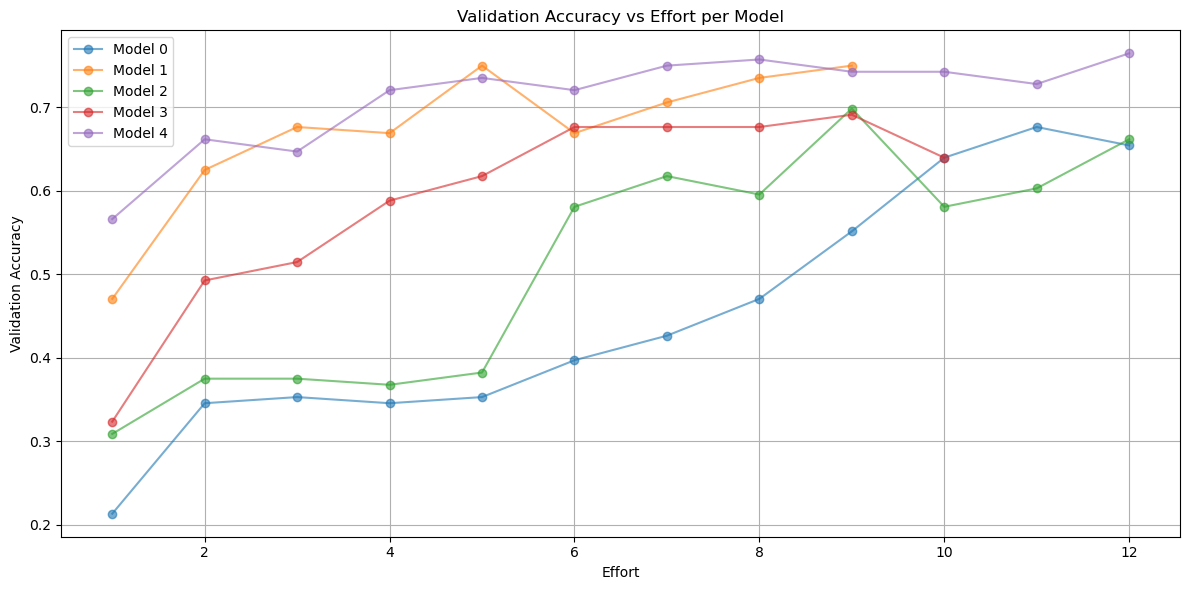

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for idx, row in results_df.head().iterrows():
    efforts = row["efforts"]
    accs = row["val_acc"]
    plt.plot(efforts, accs, label=f'Model {idx}', marker='o', alpha=0.6)

plt.axhline(y=baseline_metric, color='r', linestyle='--', label='Baseline Metric')
plt.xlabel("Effort")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs Effort per Model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Train the best models

In [13]:
from instance_sampling import create_dataloaders
from architecture_generator import create_model_from_row

In [15]:
results_df

,hidden_layers,activation_fn,dropout_rate,optimizer_type,learning_rate,weight_decay,momentum,batch_size,use_skip_connections,initializer,...,train_loss,train_acc,val_loss,val_acc,efforts,n_instances,fcst_accuracy,higher_than_baseline,last_epoch_val_acc,last_epoch_val_loss
0,"[188, 261, 485, 169, 410, 93, 366, 308]",<class 'torch.nn.modules.activation.ReLU'>,0.1,<class 'torch.optim.adam.Adam'>,0.000884,0.00001,NaN,1024,True,xavier_uniform,...,"[1.3890666961669922, 1.381540060043335, 1.3724...","[0.26296296296296295, 0.26666666666666666, 0.3...","[1.3905688524246216, 1.3788292407989502, 1.360...","[0.21323529411764705, 0.34558823529411764, 0.3...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[540, 540, 540, 540, 540, 540, 540, 540, 540, ...",0.906514,True,0.654412,0.744772
1,"[154, 419, 485, 169, 410, 93, 366, 308]",<class 'torch.nn.modules.activation.ReLU'>,0.1,<class 'torch.optim.adam.Adam'>,0.001015,0.00000,NaN,32,True,kaiming_uniform,...,"[1.3996509790420533, 1.0127235271312571, 0.780...","[0.337037037037037, 0.5425925925925926, 0.6611...","[1.0739588036256678, 0.7662547686520744, 0.584...","[0.47058823529411764, 0.625, 0.676470588235294...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]","[540, 540, 540, 540, 540, 540, 540, 540, 540]",0.787244,True,0.750000,0.643189
2,"[480, 296, 59, 458, 414, 92, 7, 61, 98, 218, 2...",<class 'torch.nn.modules.activation.LeakyReLU'>,0.0,<class 'torch.optim.sgd.SGD'>,0.001839,0.00001,0.8,64,True,kaiming_uniform,...,"[1.3787184415040192, 1.3303069520879676, 1.268...","[0.29074074074074074, 0.37592592592592594, 0.4...","[1.3776979446411133, 1.351077542585485, 1.3097...","[0.3088235294117647, 0.375, 0.375, 0.367647058...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[540, 540, 540, 540, 540, 540, 540, 540, 540, ...",0.781930,True,0.661765,0.952359
3,"[272, 313, 325, 281, 250, 259, 433, 82, 409, 272]",<class 'torch.nn.modules.activation.GELU'>,0.0,<class 'torch.optim.adamw.AdamW'>,0.000621,0.00100,NaN,512,False,kaiming_uniform,...,"[1.4827392975489297, 1.242472658333955, 1.0839...","[0.2740740740740741, 0.4185185185185185, 0.525...","[1.3302146196365356, 1.1890952587127686, 0.963...","[0.3235294117647059, 0.49264705882352944, 0.51...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[540, 540, 540, 540, 540, 540, 540, 540, 540, ...",0.778231,True,0.639706,0.786064
4,"[466, 492]",<class 'torch.nn.modules.activation.ELU'>,0.2,<class 'torch.optim.adam.Adam'>,0.005326,0.00010,NaN,64,False,kaiming_normal,...,"[1.7222408285847417, 0.9179039270789535, 0.697...","[0.5055555555555555, 0.6907407407407408, 0.716...","[1.380938643041779, 1.1637084273731007, 1.0432...","[0.5661764705882353, 0.6617647058823529, 0.647...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[540, 540, 540, 540, 540, 540, 540, 540, 540, ...",0.775491,True,0.764706,0.564918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,"[306, 471, 364, 336, 268, 261]",<class 'torch.nn.modules.activation.Tanh'>,0.4,<class 'torch.optim.adam.Adam'>,0.000382,0.00100,NaN,1024,True,xavier_uniform,...,"[1.415333867073059, 1.3482623100280762, 1.2735...","[0.2851851851851852, 0.32222222222222224, 0.40...","[1.2858941555023193, 1.2202867269515991, 1.182...","[0.4485294117647059, 0.5661764705882353, 0.529...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]","[540, 540, 540, 540, 540, 540, 540, 540]",0.535489,False,0.529412,1.082718
96,"[74, 458, 417]",<class 'torch.nn.modules.activation.GELU'>,0.5,<class 'torch.optim.sgd.SGD'>,0.022466,0.00100,0.8,512,False,kaiming_normal,...,"[2.050088788844921, 1.9411933695828474, 1.6711...","[0.28703703703703703, 0.27037037037037037, 0.4...","[1.3806828260421753, 1.2799571752548218, 1.253...","[0.40441176470588236, 0.49264705882352944, 0.5...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]","[540, 540, 540, 540, 540, 540, 540, 540]",0.521777,False,0.514706,1.283215
97,"[306, 98, 466, 43, 225]",<class 'torch.nn.modules.activation.Tanh'>,0.4,<class 'torch.optim.adam.Ad

In [ ]:
# Train till the end the best model
best_model = generation.get_best_model()

from instance_sampling import create_dataloaders

batch_size = int(results_df.loc[0, 'batch_size']) # batch size for training the model
# For training a model, DataLoader is needed
train_loader = create_dataloaders(X=X_train, y=y_train, 
                       batch_size=batch_size)
val_loader = create_dataloaders(X=X_val, y=y_val, 
                       batch_size=batch_size)
test_loader = create_dataloaders(X=X_test, y=y_test, 
                       batch_size=batch_size)

best_train_loss, best_train_acc, best_val_loss, best_val_acc = best_model.es_train(train_loader=train_loader, val_loader=val_loader,
                    es_patience=100, # epochs without improvement
                    max_epochs=1000, # cap for epochs
                    verbose=True, # print training progress
)

test_loss, test_accuracy = best_model.evaluate(test_loader)
print(f"Best model training loss: {best_train_loss:.4f}, training accuracy: {best_train_acc:.4f}")
print(f"Best model validation loss: {best_val_loss:.4f}, validation accuracy: {best_val_acc:.4f}")
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")

In [22]:

# Print the report
print('Baseline metric found by NaiveAutoMl:', baseline_metric)
print('Best neural model final (true) validation accuracy:', best_val_acc)
print('Time budget used in NaiveAutoML:', round(time_budget / 2, 4))
print('Time budget for neural models (3x Naive):', round(time_budget, 4))
print('_' * 20)
print('Best neural model forecasted accuracy:', round(results_df.loc[0, 'fcst_accuracy'], 4))
print('Best neural model final (true) validation accuracy:', round(best_val_acc, 4))
if best_val_acc < results_df.loc[0, 'fcst_accuracy']:
    print("The best model's final validation accuracy is less than the forecasted accuracy.")
else:
    print("The best model's final validation accuracy is greater or equal than the forecasted accuracy.")

if best_val_acc > baseline_metric:
    print("*The best model true validation accuracy outperforms the baseline metric*")

else:
    print("The best model true validation accuracy does not outperform the baseline metric")

    


Baseline metric found by NaiveAutoMl: 0.7333
Best neural model final (true) validation accuracy: 0.7794117647058824
Time budget used in NaiveAutoML: 123.7876
Time budget for neural models (3x Naive): 247.5752
____________________
Best neural model forecasted accuracy: 0.9065
Best neural model final (true) validation accuracy: 0.7794
The best model's final validation accuracy is less than the forecasted accuracy.
*The best model true validation accuracy outperforms the baseline metric*


# Hypothesis testing

In [17]:
n_models_to_test = 10
for n_model in range(n_models_to_test):
    print('Training model', n_model + 1, 'of', n_models_to_test)
    model = create_model_from_row(results_df.iloc[n_model], input_size, output_size)
    batch_size = int(results_df.iloc[n_model]['batch_size'])  # batch size for training the model

    train_loader = create_dataloaders(X=X_train, y=y_train, 
                        batch_size=batch_size)
    val_loader = create_dataloaders(X=X_val, y=y_val, 
                        batch_size=batch_size)
    test_loader = create_dataloaders(X=X_test, y=y_test, 
                        batch_size=batch_size)
    
    # Train the model
    final_train_loss, final_train_acc, final_val_loss, final_val_acc = model.es_train(train_loader=train_loader, val_loader=val_loader,
                    es_patience=100, # epochs without improvement
                    max_epochs=1000, # cap for epochs
                    verbose=False, # print training progress
    )
    # Build dataframe with new column
    results_df.loc[n_model, 'final_train_acc'] = final_train_acc
    results_df.loc[n_model, 'final_val_acc'] = final_val_acc



Training model 1 of 10
Training model 2 of 10
Training model 3 of 10
Training model 4 of 10
Training model 5 of 10
Training model 6 of 10
Training model 7 of 10
Training model 8 of 10
Training model 9 of 10
Training model 10 of 10


In [23]:

report = bm.run_hypothesis_and_report(
    baseline_scores=scoreboard,
    nn_scores=results_df,
    mode = "non_inferiority",
    alpha = 0.05,
    margin = 0.01,
    detail = "long",
    metric = 'fcst_accuracy'
    
)
print(report)

[NON INFERIORITY] Significant: NO | NN models may be worse than baseline.
Hypothesis test (non inferiority): Mann-Whitney U (non-inferiority)
Baseline mean = 0.7807, NN mean = 0.6794, Mean diff = -0.1013
p-value = 1.623e-09 | Significant: NO
--- Detailed Stats ---
Effect Size (d)   : -0.938
Normality Assumed : False


In [24]:
results_df['final_val_acc'].mean()

np.float64(0.8191176470588235)

In [25]:
results_df.head()

,hidden_layers,activation_fn,dropout_rate,optimizer_type,learning_rate,weight_decay,momentum,batch_size,use_skip_connections,initializer,...,val_loss,val_acc,efforts,n_instances,fcst_accuracy,higher_than_baseline,last_epoch_val_acc,last_epoch_val_loss,final_train_acc,final_val_acc
0,"[188, 261, 485, 169, 410, 93, 366, 308]",<class 'torch.nn.modules.activation.ReLU'>,0.1,<class 'torch.optim.adam.Adam'>,0.000884,0.00001,NaN,1024,True,xavier_uniform,...,"[1.3905688524246216, 1.3788292407989502, 1.360...","[0.21323529411764705, 0.34558823529411764, 0.3...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[540, 540, 540, 540, 540, 540, 540, 540, 540, ...",0.906514,True,0.654412,0.744772,0.931481,0.823529
1,"[154, 419, 485, 169, 410, 93, 366, 308]",<class 'torch.nn.modules.activation.ReLU'>,0.1,<class 'torch.optim.adam.Adam'>,0.001015,0.00000,NaN,32,True,kaiming_uniform,...,"[1.0739588036256678, 0.7662547686520744, 0.584...","[0.47058823529411764, 0.625, 0.676470588235294...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]","[540, 540, 540, 540, 540, 540, 540, 540, 540]",0.787244,True,0.750000,0.643189,0.972222,0.838235
2,"[480, 296, 59, 458, 414, 92, 7, 61, 98, 218, 2...",<class 'torch.nn.modules.activation.LeakyReLU'>,0.0,<class 'torch.optim.sgd.SGD'>,0.001839,0.00001,0.8,64,True,kaiming_uniform,...,"[1.3776979446411133, 1.351077542585485, 1.3097...","[0.3088235294117647, 0.375, 0.375, 0.367647058...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[540, 540, 540, 540, 540, 540, 540, 540, 540, ...",0.781930,True,0.661765,0.952359,0.998148,0.764706
3,"[272, 313, 325, 281, 250, 259, 433, 82, 409, 272]",<class 'torch.nn.modules.activation.GELU'>,0.0,<class 'torch.optim.adamw.AdamW'>,0.000621,0.00100,NaN,512,False,kaiming_uniform,...,"[1.3302146196365356, 1.1890952587127686, 0.963...","[0.3235294117647059, 0.49264705882352944, 0.51...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[540, 540, 540, 540, 540, 540, 540, 540, 540, ...",0.778231,True,0.639706,0.786064,0.953704,0.786765
4,"[466, 492]",<class 'torch.nn.modules.activation.ELU'>,0.2,<class 'torch.optim.adam.Adam'>,0.005326,0.00010,NaN,64,False,kaiming_normal,...,"[1.380938643041779, 1.1637084273731007, 1.0432...","[0.5661764705882353, 0.6617647058823529, 0.647...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[540, 540, 540, 540, 540, 540, 540, 540, 540, ...",0.775491,True,0.764706,0.564918,0.931481,0.845588


In [26]:

# Test with same amount of candidates
sub_results_df = results_df.head(10)


report = bm.run_hypothesis_and_report(
    baseline_scores=scoreboard,
    nn_scores=sub_results_df,
    mode = "non_inferiority",
    alpha = 0.05,
    margin = 0.01,
    detail = "long",
    metric = 'fcst_accuracy'
)
print(report)

[NON INFERIORITY] Significant: YES | NN models are competitive (not worse than baseline).
Hypothesis test (non inferiority): Mann-Whitney U (non-inferiority)
Baseline mean = 0.7807, NN mean = 0.7878, Mean diff = 0.0071
p-value = 0.4044 | Significant: YES
--- Detailed Stats ---
Effect Size (d)   : 0.203
Normality Assumed : False


In [32]:
results_df

,hidden_layers,activation_fn,dropout_rate,optimizer_type,learning_rate,weight_decay,momentum,batch_size,use_skip_connections,initializer,...,val_loss,val_acc,efforts,n_instances,fcst_accuracy,higher_than_baseline,last_epoch_val_acc,last_epoch_val_loss,final_train_acc,final_val_acc
0,"[188, 261, 485, 169, 410, 93, 366, 308]",<class 'torch.nn.modules.activation.ReLU'>,0.1,<class 'torch.optim.adam.Adam'>,0.000884,0.00001,NaN,1024,True,xavier_uniform,...,"[1.3905688524246216, 1.3788292407989502, 1.360...","[0.21323529411764705, 0.34558823529411764, 0.3...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[540, 540, 540, 540, 540, 540, 540, 540, 540, ...",0.906514,True,0.654412,0.744772,0.931481,0.823529
1,"[154, 419, 485, 169, 410, 93, 366, 308]",<class 'torch.nn.modules.activation.ReLU'>,0.1,<class 'torch.optim.adam.Adam'>,0.001015,0.00000,NaN,32,True,kaiming_uniform,...,"[1.0739588036256678, 0.7662547686520744, 0.584...","[0.47058823529411764, 0.625, 0.676470588235294...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]","[540, 540, 540, 540, 540, 540, 540, 540, 540]",0.787244,True,0.750000,0.643189,0.972222,0.838235
2,"[480, 296, 59, 458, 414, 92, 7, 61, 98, 218, 2...",<class 'torch.nn.modules.activation.LeakyReLU'>,0.0,<class 'torch.optim.sgd.SGD'>,0.001839,0.00001,0.8,64,True,kaiming_uniform,...,"[1.3776979446411133, 1.351077542585485, 1.3097...","[0.3088235294117647, 0.375, 0.375, 0.367647058...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[540, 540, 540, 540, 540, 540, 540, 540, 540, ...",0.781930,True,0.661765,0.952359,0.998148,0.764706
3,"[272, 313, 325, 281, 250, 259, 433, 82, 409, 272]",<class 'torch.nn.modules.activation.GELU'>,0.0,<class 'torch.optim.adamw.AdamW'>,0.000621,0.00100,NaN,512,False,kaiming_uniform,...,"[1.3302146196365356, 1.1890952587127686, 0.963...","[0.3235294117647059, 0.49264705882352944, 0.51...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[540, 540, 540, 540, 540, 540, 540, 540, 540, ...",0.778231,True,0.639706,0.786064,0.953704,0.786765
4,"[466, 492]",<class 'torch.nn.modules.activation.ELU'>,0.2,<class 'torch.optim.adam.Adam'>,0.005326,0.00010,NaN,64,False,kaiming_normal,...,"[1.380938643041779, 1.1637084273731007, 1.0432...","[0.5661764705882353, 0.6617647058823529, 0.647...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[540, 540, 540, 540, 540, 540, 540, 540, 540, ...",0.775491,True,0.764706,0.564918,0.931481,0.845588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,"[306, 471, 364, 336, 268, 261]",<class 'torch.nn.modules.activation.Tanh'>,0.4,<class 'torch.optim.adam.Adam'>,0.000382,0.00100,NaN,1024,True,xavier_uniform,...,"[1.2858941555023193, 1.2202867269515991, 1.182...","[0.4485294117647059, 0.5661764705882353, 0.529...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]","[540, 540, 540, 540, 540, 540, 540, 540]",0.535489,False,0.529412,1.082718,NaN,NaN
96,"[74, 458, 417]",<class 'torch.nn.modules.activation.GELU'>,0.5,<class 'torch.optim.sgd.SGD'>,0.022466,0.00100,0.8,512,False,kaiming_normal,...,"[1.3806828260421753, 1.2799571752548218, 1.253...","[0.40441176470588236, 0.49264705882352944, 0.5...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]","[540, 540, 540, 540, 540, 540, 540, 540]",0.521777,False,0.514706,1.283215,NaN,NaN
97,"[306, 98, 466, 43, 225]",<class 'torch.nn.modules.activation.Tanh'>,0.4,<class 'torch.optim.adam.Adam'>,0.000670,0.01000,NaN,1024,False,xavier_uniform,...,"[1.339337706565857, 1.309939980506897, 1.28633...","[0.35294117647058826, 0.3602941176470588, 0.36...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[540, 540, 540, 540, 540, 540, 540, 540, 540, ...",0.480529,False,0.492647,1.146260,NaN,NaN
98,"[126, 239]",<class 'torch.nn.modules.activation.ELU'>,0.1,<class 'torch.optim.adamw.AdamW'>,0.004131,0.00001,NaN,32,True,kaiming_normal,...,[0.7048103458741132],[0.7132352941176471],[1.0],[540],0.000000,False,0.713235,0.704810,NaN,NaN


In [36]:
results_df['final_val_acc'].isna().any()

np.True_

In [ ]:
testing_df = results_df.dropna(subset=['final_val_acc'])
# Correlation bw fcs t accuracy and final validation accuracy
import scipy.stats as stats
correlation, p_value = stats.pearsonr(testing_df['fcst_accuracy'], testing_df['final_val_acc'])
print(f"Correlation between forecasted accuracy and final validation accuracy: {correlation:.4f}, p-value: {p_value:.4f}")

Correlation between forecasted accuracy and final validation accuracy: 0.0376, p-value: 0.9179


: 